# Age Estimation
## Deep Leaming Image Regression
*   Dataset : fg-net-dataset
*   This is a facial image dataset that contain 1002 images and 1002 points.
*   The groundtruth is used to name each image. For example, 065A11JPG, means that this is the
No: 65' person's image when he/she was 11 years old. 'A' is short for Age.
*   Train a convolutional neural network to predict human age based on his/her face.
    
    **Hint: You may crop only their face by using face detection first. Face detection code has been provided in resource folder. **

* Use your model to predict faces on the internet:
    * Age 32 https://www1.pictures.zimbio.com/mp/QRSjX3FQD8ll.jpg
    * Age 34 https://i.dmarge.com/2017/04/fringe-part-hair.jpg
    * Age 47 https://www.troundup.com/wp-content/uploads/2017/04/tony-stark-black-sabbath-shirt-500x499.jpg

## Import library

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests
from tqdm import tqdm

# image augmentation
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.batches import UnnormalizedBatch

import dlib

import keras
import tensorflow as tf
from tensorflow.python.client import device_lib
import os
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization

In [1]:
# change this current directory to your directory
os.chdir('C:\\Users\\james\\Desktop\\J\\Kuliah\\Semester 6\\CV\\Latihan UAS\\age-estimation')
os.getcwd() 
%ls

 Volume in drive C is Windows-SSD
 Volume Serial Number is CA14-7644

 Directory of c:\Users\james\Desktop\J\Kuliah\Semester 6\CV\Latihan UAS\age-estimation

05/10/2021  07:16 PM    <DIR>          .
05/10/2021  07:16 PM    <DIR>          ..
05/10/2021  03:57 PM             1,959 .gitignore
05/10/2021  02:55 AM    <DIR>          .vscode
05/11/2021  01:31 AM         2,111,738 app.ipynb
05/10/2021  02:02 PM    <DIR>          fg-net-dataset
05/11/2021  01:35 AM           963,441 haarcascade.xml
05/10/2021  03:50 PM             1,086 LICENSE
05/10/2021  03:50 PM                16 README.md
05/10/2021  07:15 PM        99,693,937 shape_predictor_68_face_landmarks.dat
05/10/2021  07:12 PM        66,435,981 shape_predictor_68_face_landmarks_GTX.dat
               7 File(s)    169,208,158 bytes
               4 Dir(s)  202,915,807,232 bytes free


In [149]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



In [145]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6275200688449553888,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3044750132
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10359376423023880895
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [2]:
if not os.path.exists('fg-net-dataset'):
    !git clone https://gitlab.com/ykristian/fg-net-dataset

In [4]:
url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'

r = requests.get(url, stream=True)
with open('haarcascade.xml', 'w') as f:
    f.write(r.text)

In [5]:
def read_pts(filename):
    return np.loadtxt(filename, comments=("version:", "n_points:", "{", "}"))

In [229]:
def show_images(images, column_count=None, titles=None):
    assert ((titles is None) or (len(images) == len(titles)))

    n_images = len(images)
    if titles is None: titles = [f'Image {i}' for i in range(1,n_images+1)]

    if column_count == None: 
        column_count = len(images)

    fig = plt.figure(figsize=(10,6))
    for i, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(np.ceil(n_images/float(column_count)), column_count, i + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image, cmap='gray')
        a.set_title(title, fontsize=18)
    plt.show()

## Load Images & Ages

In [194]:
os.chdir('C:\\Users\\james\\Desktop\\J\\Kuliah\\Semester 6\\CV\\Latihan UAS\\age-estimation')

imgs_bgr = []
imgs_rgb = []
imgs_gray = []
for file in os.listdir('fg-net-dataset/images'):
    img_bgr = cv2.imread(f'fg-net-dataset/images/{file}')
    imgs_bgr.append(img_bgr)
    imgs_rgb.append(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    imgs_gray.append(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY))

1002
<ipython-input-210-55793c0a993e>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(np.ceil(n_images/float(column_count)), column_count, i + 1)


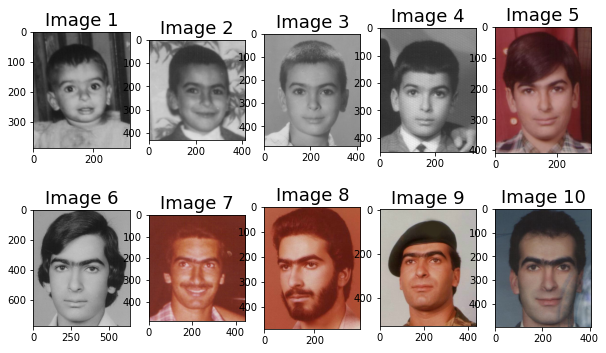

In [211]:
print(len(imgs_bgr))
show_images(imgs_rgb[0:10],5)

In [10]:
imageFileNames = os.listdir('fg-net-dataset/images/')
all_ages = [int(imageFileName.split('.')[0][4:6]) for imageFileName in imageFileNames]

print(len(all_ages))

1002


## Load Detector & Predictor using dlib

In [7]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

## Preprocess Data
There are 4 different types of Image Pre-Processing techniques and they are listed below.
* Pixel brightness transformations / Brightness corrections
    * There are two types of Brightness transformations and they are below.
        * Brightness corrections
        * Gray scale transformation
    * The most common Pixel brightness transforms operations are
        * Gamma correction or Power Law Transform
        * Sigmoid stretching 
        * Histogram equalization
* Geometric Transformations
    * Spatial transformation of the physical rearrangement of pixels in the image
    * Grey level interpolation, which assigns grey levels to the transformed image
* Image Filtering and Segmentation 
    * Some of the filtering techniques : 
        * Low Pass Filtering (Smoothing) : A low pass filter is the basis for most smoothing methods. An image is smoothed by decreasing the disparity between pixel values by averaging nearby pixels
        * High pass filters (Edge Detection, Sharpening) : High-pass filter can be used to make an image appear sharper. These filters emphasize fine details in the image – the opposite of the low-pass filter. High-pass filtering works in the same way as low-pass filtering; it just uses a different convolution kernel.
        * Directional Filtering : Directional filter is an edge detector that can be used to compute the first derivatives of an image. The first derivatives (or slopes) are most evident when a large change occurs between adjacent pixel values.Directional filters can be designed for any direction within a given space
        * Laplacian Filtering : Laplacian filter is an edge detector used to compute the second derivatives of an image, measuring the rate at which the first derivatives change. This determines if a change in adjacent pixel values is from an edge or continuous progression. Laplacian filter kernels usually contain negative values in a cross pattern, centered within the array. The corners are either zero or positive values. The center value can be either negative or positive.
    * Segmentation : 
         * Non-contextual thresholding : Thresholding is the simplest non-contextual segmentation technique. With a single threshold, it transforms a greyscale or colour image into a binary image considered as a binary region map. The binary map contains two possibly disjoint regions, one of them containing pixels with input data values smaller than a threshold and another relating to the input values that are at or above the threshold. The below are the types of thresholding techniques
            * Simple thresholding
            * Adaptive thresholding
            * Colour thresholding
        * Contextual segmentation : Non-contextual thresholding groups pixels with no account of their relative locations in the image plane. Contextual segmentation can be more successful in separating individual objects because it accounts for closeness of pixels that belong to an individual object. Two basic approaches to contextual segmentation are based on signal discontinuity or similarity. Discontinuity-based techniques attempt to find complete boundaries enclosing relatively uniform regions assuming abrupt signal changes across each boundary. Similarity-based techniques attempt to directly create these uniform regions by grouping together connected pixels that satisfy certain similarity criteria. Both the approaches mirror each other, in the sense that a complete boundary splits one region into two. The below ate the types of Contextual segmentation.
            * Pixel connectivity
            * Region similarity
            * Region growing
            * Split-and-merge segmentation
        * Texture Segmentation : Texture is most important attribute in many image analysis or computer vision applications. The procedures developed for texture problem can be subdivided into four categories.
            * structural approach
            * statistical approach
            * model based approach
            * filter based approach
            
       
* Fourier transform and Image restauration


In [11]:
def preprocess(image):
    temp = image.copy() # copy

    gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY) # bgr to grayscale
    blurred = cv2.GaussianBlur(gray, (5,5), 0) # remove noise a

    # detect faces in the grayscale image
    faces = detector(blurred, 1)
    if len(faces) < 1:
        resized = cv2.resize(blurred, (200,200), interpolation=cv2.INTER_NEAREST)
        return resized
    else: 
        for (i, face) in enumerate(faces):
            x1 = abs(face.left()) # dlib's bug return -37 
            y1 = face.top()
            x2 = face.right() + x1
            y2 = face.bottom()
            cropped = blurred[y1:y2,x1:x2]

            resized = cv2.resize(cropped, (200,200), interpolation=cv2.INTER_NEAREST)
            return resized

In [12]:
datasets = []
ages = []

for idx, image in enumerate(tqdm(imgs_bgr)): 
    ages.append(all_ages[idx])
    datasets.append(preprocess(image))
    
assert len(datasets) == len(ages)
print(len(ages))

100%|██████████| 1002/1002 [01:05<00:00, 15.30it/s]1002



<ipython-input-6-b6818bc35d5c>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images)/ column_count + 1, column_count, i + 1)
1002


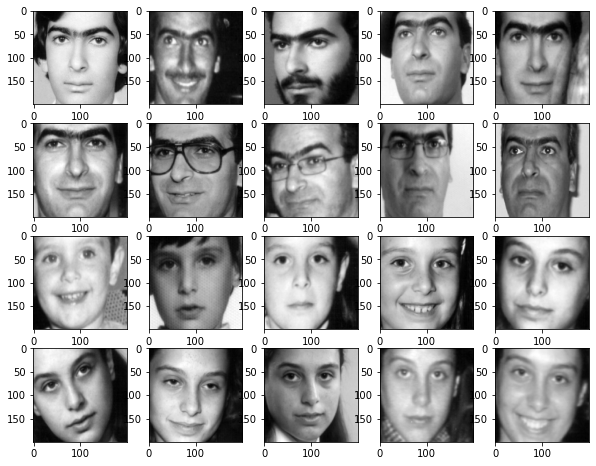

In [13]:
print(len(datasets))
show_images(datasets[5:25],5)

In [118]:
def distribution(data):
    n, bins, patches = plt.hist(x=data, bins=70, color='#0504aa',alpha=0.75,rwidth=0.5)

    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Ages distribution')
    maxfreq = n.max()

    plt.ylim(ymax=np.ceil(maxfreq/10) * 10 if maxfreq % 10 else maxfreq + 10)

47

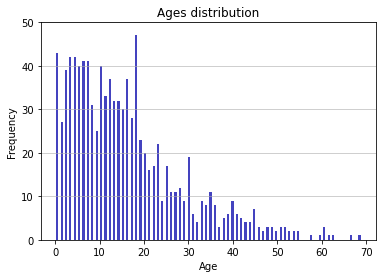

In [125]:
distribution(np.array(ages))
np.sum((np.array(ages) == 18))

Can be seen from the data mostly are between age 0 to early 20

## Commonly used Augmentation Techniques 
Some of the commonly used Image data augmentations techniques are:

* Flipping 
This means flipping the image horizontally or vertically
* Rotation 
This means to rotate the image by a given angle in the clockwise or anticlockwise direction
* Cropping 
During cropping, a section of the image is sampled randomly
* Brightness 
Increase or decrease the brightness of the image
* Scaling
Scaling Images can be scaled outward or inward. When scaled outward, the image size increases while the image size decreases when scaled inwards.
* Noise Addition
We can also add gaussian noise to the existing images.


Documentation of imgaug : https://pythonrepo.com/repo/aleju-imgaug-python-computer-vision#installation

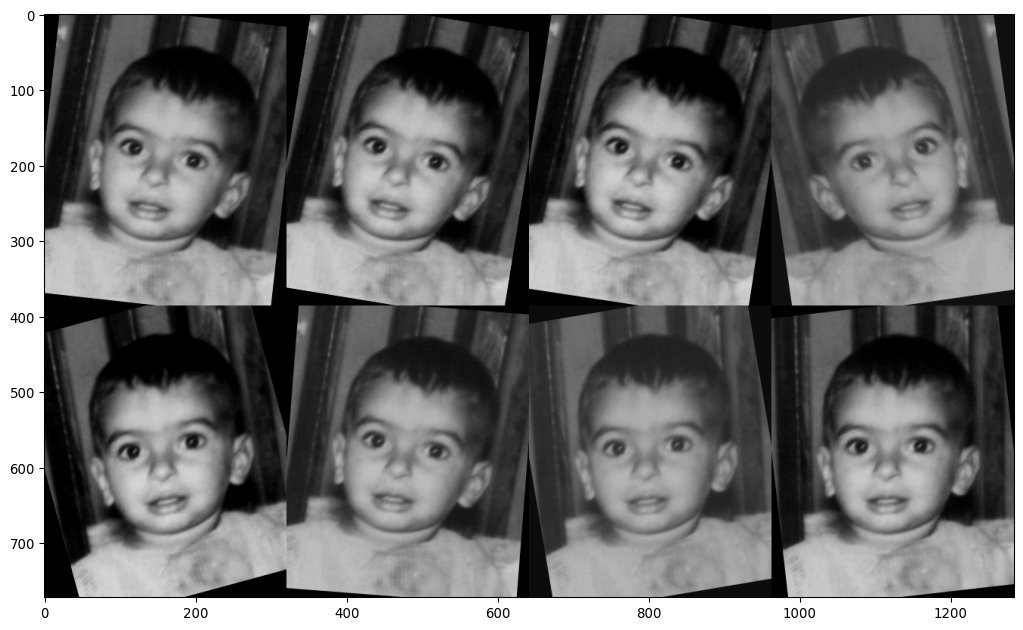

In [59]:
ia.seed(218116689)
aug = iaa.Sequential([
    iaa.Affine(
        rotate=(-25, 25),
        shear=(-8,8),
    ),    
    iaa.Fliplr(0.5), # horizontal flips
    iaa.LinearContrast((0.75,1.5)),
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0,0.5))
    ),
], random_order=True) # apply augmenters in random order

images_aug = [aug(image=imgs_rgb[0]) for _ in range(8)]
# plt.imshow(images_aug[0])
ia.imshow(ia.draw_grid(images_aug, cols=4, rows=2))

In [163]:
max_aug = 50
ia.seed(218116689)

temp_datasets = datasets.copy() 
temp_ages = ages.copy()

for img, age in zip(temp_datasets, temp_ages):
    n = max_aug - np.sum((np.array(ages) == age))
    aug = iaa.Sequential([
        iaa.Affine(
            rotate=(-25, 25),
            shear=(-8,8),
        ),    
        iaa.Fliplr(0.5), # horizontal flips
        iaa.LinearContrast((0.75,1.5)),
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0,0.5))
        ),
    ], random_order=True) # apply augmenters in random order

    for _ in range(n):
        image_aug = aug(image=img) 
        datasets.append(image_aug)
        ages.append(age)

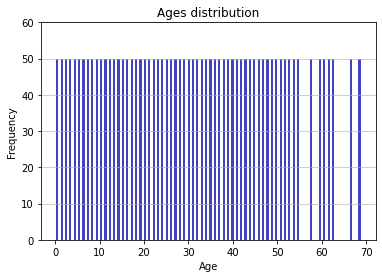

In [165]:
distribution(ages)

## Model & Training

In [166]:
x = np.array(datasets)
x = x.reshape(len(x), x.shape[1], x.shape[2], 1)
y = np.array(ages)
y = y.reshape(len(y), 1)

x.shape, y.shape

((3150, 200, 200, 1), (3150, 1))

In [167]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=218116689)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=218116689)

In [168]:
x_train.shape, x_val.shape, x_test.shape

((2268, 200, 200, 1), (630, 200, 200, 1), (252, 200, 200, 1))

In [169]:
assert len(x_train) == len(y_train)
assert len(x_val) == len(y_val)
assert len(x_test) == len(y_test)

In [170]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras import backend as K 

In [231]:
K.clear_session()

model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(200, 200, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 128)       5

In [232]:
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), batch_size=64)

Epoch 1/100
36/36 [==============================] - 15s 353ms/step - loss: 812.0850 - accuracy: 0.0179 - val_loss: 63893.3008 - val_accuracy: 0.0159
Epoch 2/100
36/36 [==============================] - 8s 232ms/step - loss: 305.2029 - accuracy: 0.0134 - val_loss: 23026.3184 - val_accuracy: 0.0159
Epoch 3/100
36/36 [==============================] - 8s 231ms/step - loss: 170.6911 - accuracy: 0.0138 - val_loss: 1209.1111 - val_accuracy: 0.0095
Epoch 4/100
36/36 [==============================] - 8s 231ms/step - loss: 123.3788 - accuracy: 0.0105 - val_loss: 659.8109 - val_accuracy: 0.0159
Epoch 5/100
36/36 [==============================] - 8s 230ms/step - loss: 79.1019 - accuracy: 0.0169 - val_loss: 597.0776 - val_accuracy: 0.0190
Epoch 6/100
36/36 [==============================] - 8s 229ms/step - loss: 59.6896 - accuracy: 0.0155 - val_loss: 602.1595 - val_accuracy: 0.0190
Epoch 7/100
36/36 [==============================] - 8s 230ms/step - loss: 48.6954 - accuracy: 0.0188 - val_loss: 

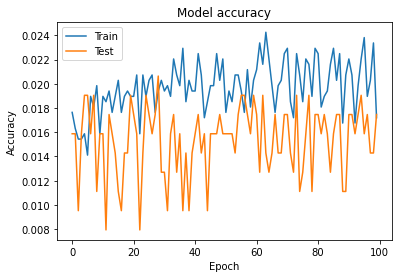

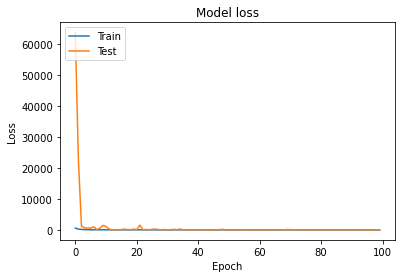

In [233]:
#rating visualization
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [234]:
urls = [
    'https://media.vertbaudet.com/Pictures/vertbaudet/98072/3-piece-outfit-gift-for-newborn-babies.jpg',
    'http://www2.pictures.zimbio.com/mp/QRSjX3FQD8ll.jpg', # 32
    'https://i.dmarge.com/2017/04/fringe-part-hair.jpg', # 34
    'https://www.troundup.com/wp-content/uploads/2017/04/tony-stark-black-sabbath-shirt-500x499.jpg', # 47
]

import requests
from PIL import Image

def url_to_image(url):
  r = requests.get(url,stream=True)
  image = np.array(Image.open(r.raw))
  return image

imgs = []
for url in urls:
    img = url_to_image(url)
    img = preprocess(img)
    img = img.reshape(200, 200, 1)
    imgs.append(img)

<ipython-input-229-0d68c3b25760>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(np.ceil(n_images/float(column_count)), column_count, i + 1)


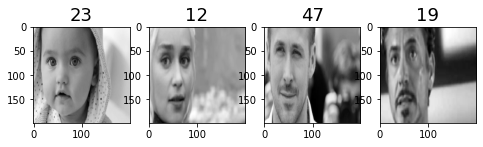

In [235]:
predictions = []
for img in imgs:
    predictions.append(model.predict(img.reshape(1,200,200,1)))

show_images(imgs,5,[str(int(p)) for p in predictions])